In [1]:
# Jupyter Notebook: Risky Location Model for Personal Security Solution (ACLED Tunisia)

# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


# Note: Tailored for ACLED Tunisia dataset (1997-2025, ~11,367 events).
# Using '../data/tunisia_acled_1997_2025.csv' (~5.7 MB).
# Filtering for 2,623 high-risk events: Riots (1905), Violence against civilians (184),
# Battles (307), Explosions/Remote violence (227), plus sub-events like Violent demonstration.
# DBSCAN eps=0.03 (tuned for Tunisia's sparse geography), min_samples=5.
# Added k-distance plot for eps estimation.
# Tunisia's area (~163,610 km²) requires smaller eps vs. Chicago (~606 km²).
# Check https://acleddata.com for codebook.
# Supplement with street crime data from Ministry/INS if needed.


Loading ACLED Tunisia Data from ../data/1900-01-01-2025-06-18-Northern_Africa-Tunisia.csv
Columns in CSV: ['event_date', 'year', 'disorder_type', 'event_type', 'sub_event_type', 'civilian_targeting', 'admin1', 'location', 'latitude', 'longitude', 'fatalities']
Total events: 11367
Shape after dropping missing coordinates: (11367, 11)
Head after dropping NaN:
      event_date  year   disorder_type event_type    sub_event_type  \
0  09 June 2025  2025  Demonstrations   Protests  Peaceful protest   
1  09 June 2025  2025  Demonstrations   Protests  Peaceful protest   
2  09 June 2025  2025  Demonstrations   Protests  Peaceful protest   
3  03 June 2025  2025  Demonstrations   Protests  Peaceful protest   
4  03 June 2025  2025  Demonstrations   Protests  Peaceful protest   

  civilian_targeting    admin1     location   latitude  longitude  fatalities  
0                NaN     Tunis        Tunis  36.819000    10.1658           0  
1                NaN  Medenine  Ben Gardane  33.137798    

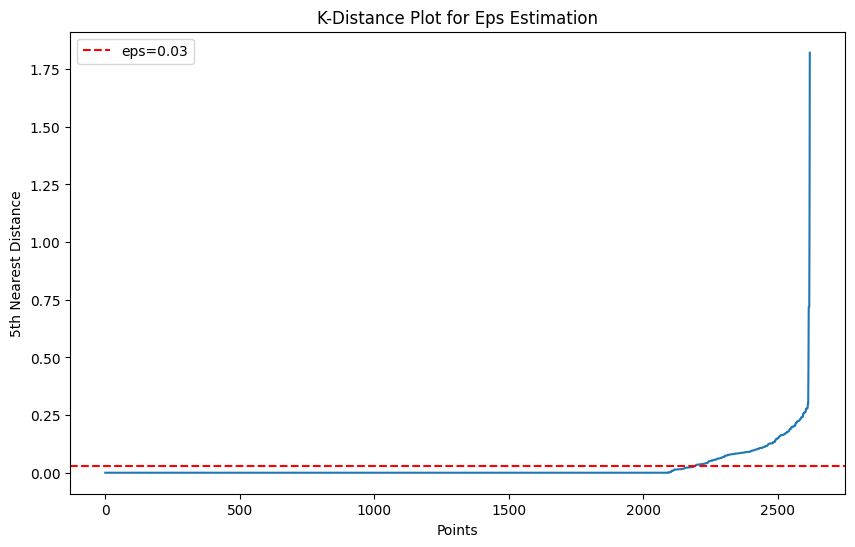

In [2]:


# Step 1: Load and preprocess ACLED data
acled_file = '../data/1900-01-01-2025-06-18-Northern_Africa-Tunisia.csv'

# Optimize data types
dtypes = {
    'latitude': 'float32',
    'longitude': 'float32',
    'event_type': 'category',
    'sub_event_type': 'category',
    'disorder_type': 'category',
    'civilian_targeting': 'category',
    'fatalities': 'int32',
    'event_date': 'object',
    'year': 'int32',
    'admin1': 'category',
    'location': 'category'
}

try:
    if os.path.exists(acled_file):
        print(f"Loading ACLED Tunisia Data from {acled_file}")
        df = pd.read_csv(acled_file, dtype=dtypes, usecols=[
            'latitude', 'longitude', 'event_type', 'sub_event_type', 'disorder_type',
            'civilian_targeting', 'fatalities', 'event_date', 'year', 'admin1', 'location'
        ])
        print("Columns in CSV:", df.columns.tolist())
        print("Total events:", len(df))
    else:
        print(f"No ACLED data found at {acled_file}.")
        print("Download from https://acleddata.com/data-export-tool/")
        raise FileNotFoundError("ACLED data missing")

    # Check required columns
    required_cols = ['latitude', 'longitude', 'event_type', 'sub_event_type', 'fatalities', 'year']
    available_cols = df.columns.tolist()
    missing_cols = [col for col in required_cols if col not in available_cols]
    if missing_cols:
        print(f"Error: Missing columns {missing_cols}. Available columns: {available_cols}")
        raise ValueError("Missing required columns")

except MemoryError:
    print("MemoryError: Insufficient RAM. Try closing other applications or running on Google Colab.")
    raise
except Exception as e:
    print(f"Error loading data: {e}. Ensure '../data/tunisia_acled_1997_2025.csv' exists.")
    raise

# Drop rows with missing coordinates
df = df.dropna(subset=['latitude', 'longitude'])
print("Shape after dropping missing coordinates:", df.shape)
print("Head after dropping NaN:\n", df.head())

# Filter for high-risk events (post-2011 for relevance)
high_risk_events = ['Violence against civilians', 'Riots', 'Battles', 'Explosions/Remote violence']
high_risk_sub_events = ['Violent demonstration', 'Mob violence', 'Attack', 'Remote explosive/landmine/IED', 'Excessive force against protesters']
df = df[(df['year'] >= 2011) & (
    df['event_type'].isin(high_risk_events) |
    df['sub_event_type'].isin(high_risk_sub_events) |
    df['civilian_targeting'].notna() |
    (df['fatalities'] > 0)
)]
print("Shape after filtering high-risk events (year>=2011):", df.shape)
print("Event types:\n", df['event_type'].value_counts())
print("Sub-event types:\n", df['sub_event_type'].value_counts())
print("Fatalities distribution:\n", df['fatalities'].value_counts())
print("Head after filtering:\n", df.head())

# Check if data is sufficient
if df.shape[0] < 500:
    print("Warning: Only", df.shape[0], "high-risk events found. Consider:")
    print("1. Including Protests with civilian_targeting.")
    print("2. Adding synthetic data for urban areas (e.g., Tunis).")
    print("3. Acquiring street crime data from Ministry/INS.")
    print("Event types before filtering:\n", pd.read_csv(acled_file, usecols=['event_type'])['event_type'].value_counts())

# Extract features
X = df[['latitude', 'longitude']].values
print("Coordinate ranges - Latitude: [{:.4f}, {:.4f}]".format(df['latitude'].min(), df['latitude'].max()))
print("Coordinate ranges - Longitude: [{:.4f}, {:.4f}]".format(df['longitude'].min(), df['longitude'].max()))

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled data shape:", X_scaled.shape)
print("Scaled coordinate ranges - Latitude: [{:.2f}, {:.2f}]".format(X_scaled[:,0].min(), X_scaled[:,0].max()))
print("Scaled coordinate ranges - Longitude: [{:.2f}, {:.2f}]".format(X_scaled[:,1].min(), X_scaled[:,1].max()))

# Plot k-distance to estimate eps
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X_scaled)
distances, _ = neigh.kneighbors(X_scaled)
distances = np.sort(distances[:, 4])
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('5th Nearest Distance')
plt.title('K-Distance Plot for Eps Estimation')
plt.axhline(y=0.03, color='r', linestyle='--', label='eps=0.03')
plt.legend()
plt.show()


In [ ]:

# Step 2: Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.03, min_samples=5, metric='euclidean') #0.01 , 3
clusters = dbscan.fit_predict(X_scaled)
df['Cluster'] = clusters

# Debug clustering
print("Cluster counts:\n", df['Cluster'].value_counts())
if (df['Cluster'] == -1).all():
    print("Warning: All points are noise. Try increasing eps (e.g., 0.05) or min_samples (e.g., 3).")


Cluster counts:
 Cluster
 6      368
-1      198
 27     127
 11      72
 13      71
       ... 
 107      3
 112      3
 38       3
 117      3
 144      3
Name: count, Length: 146, dtype: int64


In [9]:

# Step 3: Assign risk scores
cluster_counts = df[df['Cluster'] != -1]['Cluster'].value_counts()
print("Cluster counts (non-noise):\n", cluster_counts)
if cluster_counts.empty:
    print("Warning: No clusters formed. Try increasing eps (e.g., 0.05) or min_samples (e.g., 3).")
    df['Risk_Score'] = 0.0
else:
    df['Risk_Score'] = df['Cluster'].map(cluster_counts).fillna(0) / cluster_counts.max()


Cluster counts (non-noise):
 Cluster
6      368
27     127
11      72
13      71
19      66
      ... 
107      3
112      3
38       3
117      3
144      3
Name: count, Length: 145, dtype: int64


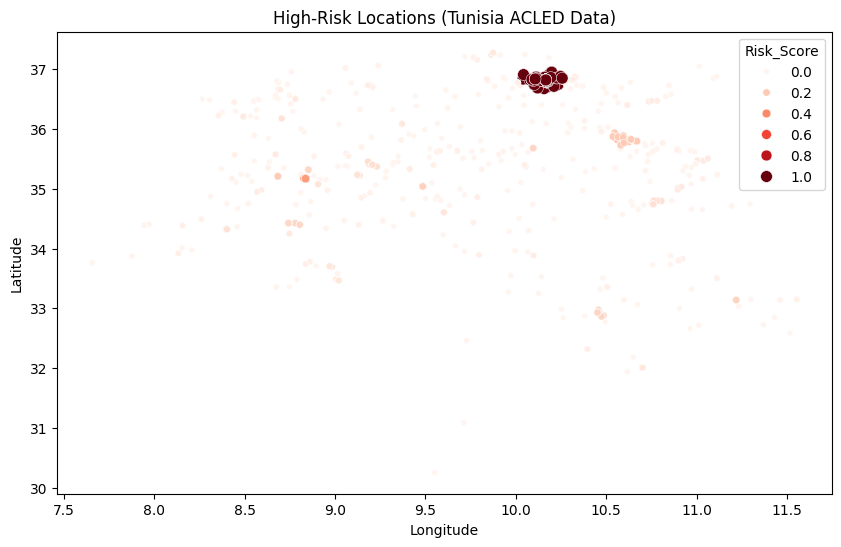

In [10]:

# Step 4: Visualize results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='Risk_Score', size='Risk_Score', palette='Reds')
plt.title('High-Risk Locations (Tunisia ACLED Data)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:

# Step 5: Predict risk score
def predict_risk_score(lat, lon, model, scaler, cluster_counts):
    X_new = np.array([[lat, lon]], dtype=np.float32)
    X_new_scaled = scaler.transform(X_new)
    # Find nearest core point
    if len(model.components_) == 0:
        print("No core points in model. Increase eps/min_samples or add more data.")
        return 0.0
    distances = np.sqrt(((X_new_scaled - model.components_)**2).sum(axis=1))
    nearest_idx = np.argmin(distances)
    if distances[nearest_idx] <= model.eps:
        cluster = model.labels_[model.core_sample_indices_[nearest_idx]]
        score = cluster_counts.get(cluster, 0) / (cluster_counts.max() if not cluster_counts.empty else 1)
        print(f"Assigned to cluster {cluster} with risk score {score:.2f}")
    else:
        print(f"Point classified as noise (distance {distances[nearest_idx]:.2f} > eps {model.eps})")
        score = 0.0
    return score

# Example predictions (Tunisia coordinates)
test_points = [
    (36.8065, 10.1815),  # Tunis
    (33.8815, 10.0982),  # Gabes
    (35.6754, 10.1033)   # Kairouan
]
for lat, lon in test_points:
    risk_score = predict_risk_score(lat, lon, dbscan, scaler, cluster_counts)
    print(f'Risk Score for ({lat}, {lon}): {risk_score:.2f}')


Assigned to cluster 6 with risk score 1.00
Risk Score for (36.8065, 10.1815): 1.00
Assigned to cluster 28 with risk score 0.04
Risk Score for (33.8815, 10.0982): 0.04
Assigned to cluster 2 with risk score 0.16
Risk Score for (35.6754, 10.1033): 0.16


In [12]:

# Step 6: Save model
import joblib
joblib.dump(dbscan, 'risky_location_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']